In [53]:
import os
import re
import glob
from datetime import datetime
import sys
sys.path.append("..") # Adds higher directory to python modules path for importing from src dir

import pandas as pd
import numpy as np
import tqdm
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 547 ms


In [3]:
HOME = ".."
DATA_DIR = "data"
REUTERS = os.path.join(HOME, DATA_DIR, "preprocessed", "news_reuters.csv")
BLOOMBERG = os.path.join(HOME, DATA_DIR, "preprocessed", "news_bloomberg.csv")
NEWS = os.path.join(HOME, DATA_DIR, "preprocessed", "news.csv")
# Columns: 'date', 'filename', 'content'

time: 26.3 ms


### Get companies

In [5]:
from src.datasets import NyseSecuritiesDataset
from src.datasets import NyseStocksDataset
import src.nlp_utils as nlp_utils

time: 540 ms


In [6]:
securities_ds = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv')
companies = securities_ds.get_all_company_names()  # List[Tuple[symbol, name]]

time: 44 ms


Reuters:
- 106519 articles
- From 2006-10-20 to 2013-11-20
- 45363 before 2010-01-04

Bloomberg:
- 448395 articles
- From 2006-10-20 to 2013-11-26
- 1148 before 2010-01-04

Nyse:
- From 2010-01-04 to 2016-12-30

45363


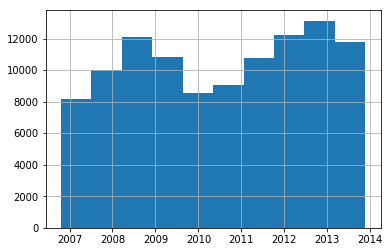

time: 1.7 s


In [9]:
dates_r = pd.read_csv(REUTERS, usecols=[0, 1], index_col=0)
dates_r['date'] = pd.to_datetime(dates_r['date'], errors='coerce')
dates_r['date'].hist()
print(sum(dates_r['date'] <= pd.to_datetime('2010-01-04')))

1148


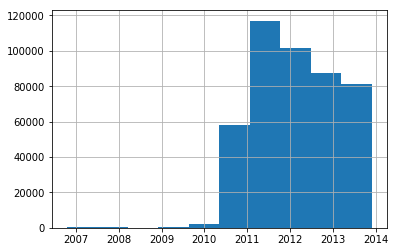

time: 6.77 s


In [10]:
dates_b = pd.read_csv(BLOOMBERG, usecols=[0, 1], index_col=0)
dates_b['date'] = pd.to_datetime(dates_b['date'], errors='coerce')
dates_b['date'].hist()
print(sum(dates_b['date'] <= pd.to_datetime('2010-01-04')))

# Multi Run

In [13]:
bloombergs = pd.read_csv(BLOOMBERG, nrows=1148, index_col=0)

time: 68.3 ms


In [14]:
reuters = pd.read_csv(REUTERS, nrows=45363, index_col=0)

time: 1.4 s


In [79]:
pd.concat([bloombergs, reuters]).shape

(46511, 3)

time: 25.9 ms


In [19]:
from pyxdameraulevenshtein import normalized_damerau_levenshtein_distance

time: 22.8 ms


In [81]:
bloombergs.iloc[0]

date                                               2006-10-20
filename    inco-s-net-soars-on-higher-metal-prices-breaku...
content     -- Inco's Net Soars on Higher Metal Prices, Br...
Name: 0, dtype: object

time: 23.7 ms


In [21]:
normalized_damerau_levenshtein_distance("Inco", "Fidelity National Information Services")

0.02631578966975212

time: 556 ms


In [ ]:
results = []
for i, article in tqdm(bloombergs.iterrows(), total=1148):
    # One full article takes about 7 seconds
    found_entities = nlp_utils.find_nyse_corporations(article[2], quiet=True)
    if len(found_entities):
        results.append((i, 'bloomberg', found_entities))
for i, article in tqdm(reuters.iterrows(), total=45363):
    # One full article takes about 7 seconds
    found_entities = nlp_utils.find_nyse_corporations(article[2], quiet=True)
    if len(found_entities):
        results.append((i, 'reuters', found_entities))

In [85]:
results

[(1,
  'bloomberg',
  [(Philip Morris, 'PM'),
   (Yahoo, 'YHOO'),
   (Yahoo, 'YHOO'),
   (General Motors Corp., 'GM'),
   (Ford Motor Co., 'F'),
   (Merck & Co., 'MRK')]),
 (3, 'bloomberg', [(Bristol-Myers Squibb Co., 'BMY')]),
 (4,
  'bloomberg',
  [(Allergan Inc., 'AGN'),
   (Estee Lauder, 'EL'),
   (Colgate-Palmolive Co., 'CL'),
   (Caterpillar Inc., 'CAT'),
   (Cummins Inc., 'CMI'),
   (Caterpillar, 'CAT'),
   (FedEx Corp., 'FDX'),
   (Johnson & Johnson, 'JNJ'),
   (Altria Group Inc., 'MO')])]

time: 29.2 ms


### Apply on Reuters Article

In [54]:
# idxmax reuters: 61727  (FB 26, MSFT 1, NWSA 44, NWS 44, YHOO 1)
reuters = pd.read_csv(REUTERS, skiprows=61727, nrows=1, index_col=0)
print(reuters.loc[61727][2])

-- Special report: How News Corp got lost in Myspace
-- By  Yinka Adegoke
-- Thu Apr 7, 2011 1:08pm EDT
-- http://www.reuters.com/article/2011/04/07/us-myspace-idUSTRE7364G420110407

 

 NEW YORK  (Reuters) - As Rupert Murdoch stepped into the Grand Ballroom of San Francisco's Palace Hotel at the Web 2.0 conference in October 2007, the developers and engineers who packed the room fell into a respectful hush. It was the sort of greeting usually reserved for one of their own tech heroes, not a 76-year-old media mogul. 

 Sitting cross-legged on a red leather couch, Murdoch looked relaxed in an open-necked shirt. Next to him sat Chris De Wolfe, the co-founder of Myspace, the social network that News Corp's chairman had acquired for $580 million two years earlier. De Wolfe had spent weeks trying to sell Murdoch's advisers on the conference, which he saw as a kind of digital coming out party for his boss. But those close to the News Corp chairman worried he might embarrass himself in front 

In [61]:
article1 = nlp(reuters.loc[61727][2])
labels = [x.label_ for x in article1.ents]
print(Counter(labels))
items = [x.text for x in article1.ents if x.label_ == 'ORG']
print(Counter(items))  # .most_common(3)
sentences = [x for x in article1.sents]
print(sentences[20])
displacy.render(nlp(str(sentences[20])), jupyter=True, style='ent')

Counter({'ORG': 234, 'PERSON': 117, 'DATE': 76, 'CARDINAL': 33, 'GPE': 26, 'MONEY': 15, 'ORDINAL': 13, 'PERCENT': 7, 'FAC': 4, 'LOC': 3, 'NORP': 2, 'TIME': 1, 'PRODUCT': 1, 'WORK_OF_ART': 1})
Counter({'Myspace': 100, 'News Corp': 34, 'Facebook': 24, "News Corp's": 8, 'Google': 5, 'Viacom': 4, 'Reuters': 3, 'Allen & Co': 2, 'Sony Music': 2, 'Yahoo': 2, 'Microsoft': 2, 'AOL': 2, 'Miller': 2, 'Museum of Modern Art': 1, 'Austin Ventures': 1, 'Universal Music': 1, 'Abu Dhabi Holdings': 1, 'FAILURES Plenty': 1, 'AOL-Time Warner': 1, 'Delphi': 1, 'Fox Interactive Media': 1, 'MarketWatch': 1, 'Career Search': 1, 'IGN': 1, 'CNET': 1, 'Intermix Media': 1, 'Redpoint Ventures': 1, 'Intermix': 1, 'Redstone': 1, 'Freston': 1, 'News Corp.': 1, 'FarmVille': 1, 'BTIG': 1, 'Fox Interactive': 1, 'TOM': 1, 'Dow Jones': 1, 'the Wall Street Journal': 1, "Microsoft Corp's": 1, 'Yahoo Inc.': 1, 'Universal Music Group': 1, 'Warner Music Group': 1, 'EMI Music': 1, 'Myspace Music': 1, 'Paris Hilton': 1, 'Chernin

time: 1.83 s


In [9]:
counts = Counter([ent for ent, label in zip(items, labels) if label == 'ORG'])
matches = [
    [key, counts[key], securities_ds.get_most_similar_company(key)] for key in counts]
matches = [x for x in matches if x[2] is not None]
matched_stocks = dict([(x[0], x[2]) for x in matches])
matches

[["News Corp's", 8, 'News Corp.'],
 ['News Corp', 34, 'News Corp.'],
 ['Facebook', 24, 'Facebook'],
 ['AOL-Time Warner', 1, 'Time Warner Inc.'],
 ['Viacom', 4, 'Viacom Inc.'],
 ['News Corp.', 1, 'News Corp.'],
 ['Yahoo', 2, 'Yahoo Inc.'],
 ['Microsoft', 2, 'Microsoft Corp.'],
 ["Microsoft Corp's", 1, 'Microsoft Corp.'],
 ['Yahoo Inc.', 1, 'Yahoo Inc.'],
 ['Time Warner', 1, 'Time Warner Inc.'],
 ['Apple', 1, 'Apple Inc.']]

time: 1.18 s


In [67]:
securities_ds.get_most_similar_company('AOL-Time Warner', quiet=False)

                  Name  damerau_lev
441   Time Warner Inc.     0.266667
72          BorgWarner     0.600000
93              Cerner     0.666667
172  Estee Lauder Cos.     0.666667
5    Acuity Brands Inc     0.666667


'Time Warner Inc.'

time: 155 ms


In [66]:
found_entities = nlp_utils.find_nyse_corporations(reuters.loc[61727][2], quiet=False)

Found organisations: 234


time: 2.71 s


### Apply on Bloomberg Article

In [71]:
# idxmax bloomberg: 316777  (AAPL 1, FB 79, JPM 1, MSFT 1, MS 7)
bloomberg = pd.read_csv(BLOOMBERG, skiprows=316777, nrows=1, index_col=0)
# print(bloomberg.loc[316777][2])

time: 2.74 s


In [76]:
found_entities = nlp_utils.find_nyse_corporations(bloomberg.loc[316777][2], quiet=False)

Found ORG occurrences: 208
Organsations after filtering:
 - ORG (FB): 72
 - ORG (MS): 7
 - ORG (GS): 4
 - ORG (AAPL): 1
 - ORG (JPM): 1
 - ORG (MSFT): 1


time: 4.02 s
